In [490]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

In [491]:
os.environ["PYTHONHASHSEED"] = str(42)
tf.random.set_seed(42)
np.random.seed(42)

In [492]:
train_noisy_path = r"C:\Users\91909\Desktop\ML\DATA\NTIRE\noisy_data\DIV2K\DIV2K_train_HR\DIV2K_train_HR"
train_clean_path = r"C:\Users\91909\Desktop\ML\DATA\NTIRE\clean_data\DIV2K\DIV2K_train_HR\DIV2K_train_HR"

val_noisy_path = r"C:\Users\91909\Desktop\ML\DATA\NTIRE\noisy_data\DIV2K\DIV2K_valid_HR\DIV2K_valid_HR"
val_clean_path = r"C:\Users\91909\Desktop\ML\DATA\NTIRE\clean_data\DIV2K\DIV2K_valid_HR\DIV2K_valid_HR"

In [493]:
BATCH_SIZE = 1
# HEIGHT, WIDTH = 256, 256
PATCH_SIZE = 128
EPOCHS = 15
LEARNING_RATE = 0.0001

In [494]:
def conv_block(ip, num_filters):
        x = Conv2D(num_filters, 3, padding="same")(ip)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        x = Conv2D(num_filters, 3, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        return x

In [495]:
def encoder_block(ip, num_filters):
        x = conv_block(ip, num_filters)
        p = MaxPool2D((2, 2))(x)
        return p, x

In [496]:
def decoder_block(ip, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(ip)
    # Resize x to match skip if their shapes mismatch
    if x.shape[1] != skip.shape[1] or x.shape[2] != skip.shape[2]:
        x = tf.image.resize(x, (skip.shape[1], skip.shape[2]))
    x = Concatenate()([x, skip])
    x = conv_block(x, num_filters)
    return x

In [497]:
def extract_patches(noise, clean, patch_size=PATCH_SIZE):
    h, w, _ = noise.shape
    patches_noise, patches_clean = [], []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch_noise = noise[i:i+patch_size, j:j+patch_size]
            patch_clean = clean[i:i+patch_size, j:j+patch_size]
            if patch_noise.shape[:2] == (patch_size, patch_size):
                patches_noise.append(patch_noise)
                patches_clean.append(patch_clean)
    return np.array(patches_noise), np.array(patches_clean)

In [498]:
def visualize_patches(noise, clean, num_samples=5):
    plt.figure(figsize=(10, num_samples * 2))
    for i in range(num_samples):
        idx = np.random.randint(0, len(noise))
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(noise[idx])
        plt.title("Input Patch")
        plt.axis("off")

        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(clean[idx].squeeze(), cmap="gray")
        plt.title("Mask Patch")
        plt.axis("off")
    plt.show()

In [499]:
def tf_parse(x, y):
    x = tf.cast(x, tf.float32)
    y = tf.cast(y, tf.float32)
    return x, y

def tf_dataset(x, y, batch=4):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [500]:
def load_images_in_batches(noisy_path, clean_path, batch_size=BATCH_SIZE, patch_size=PATCH_SIZE):
    noisy_images = sorted(glob(os.path.join(noisy_path, "*")))
    clean_images = sorted(glob(os.path.join(clean_path, "*")))

    for i in range(0, len(noisy_images), batch_size):
        batch_noise, batch_clean = [], []
        
        for j in range(i, min(i + batch_size, len(noisy_images))):
            img_noise = cv2.imread(noisy_images[j], cv2.IMREAD_COLOR) / 255.0
            img_clean = cv2.imread(clean_images[j], cv2.IMREAD_COLOR) / 255.0
            
            patches_noise, patches_clean = extract_patches(img_noise, img_clean, patch_size)
            batch_noise.extend(patches_noise)
            batch_clean.extend(patches_clean)

        yield np.array(batch_noise), np.array(batch_clean)

# Example usage:
train_batch_gen = load_images_in_batches(train_noisy_path, train_clean_path, batch_size=BATCH_SIZE)
val_batch_gen = load_images_in_batches(val_noisy_path, val_clean_path, batch_size=BATCH_SIZE)

x_train, y_train = next(train_batch_gen)
x_val, y_val = next(val_batch_gen)

In [501]:
# train_dataset = tf_dataset(x_train, y_train, batch=BATCH_SIZE)
# val_dataset = tf_dataset(x_val, y_val, batch=BATCH_SIZE)

In [502]:
# def visualize_patches(noise, clean, num_samples=5):
#     """Visualizes random patches from noisy and clean images."""
#     plt.figure(figsize=(10, num_samples * 2))

#     for i in range(num_samples):
#         idx = np.random.randint(0, len(noise))  # Random index selection

#         plt.subplot(num_samples, 2, 2 * i + 1)
#         plt.imshow(noise[idx])
#         plt.title("Noisy Patch")
#         plt.axis("off")

#         plt.subplot(num_samples, 2, 2 * i + 2)
#         plt.imshow(clean[idx])
#         plt.title("Clean Patch")
#         plt.axis("off")

#     plt.show()

In [503]:
# all_noisy_patches, all_clean_patches = [], []

# batch_gen = load_images_in_batches(noisy_path, clean_path, batch_size=4)
# for x_batch, y_batch in batch_gen:
#     all_noisy_patches.extend(x_batch)
#     all_clean_patches.extend(y_batch)

# all_noisy_patches = np.array(all_noisy_patches)
# all_clean_patches = np.array(all_clean_patches)

# # Split dataset into train and validation sets
# x_train, x_val, y_train, y_val = train_test_split(
#     all_noisy_patches, all_clean_patches, test_size=0.2, random_state=42
# )

# # Visualize 5 random patches
# visualize_patches(x_train, y_train, num_samples=5)

In [504]:
def unet(ip_shape):
    ip = Input(ip_shape)

    s1, p1 = encoder_block(ip, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 80)
    s4, p4 = encoder_block(p3, 96)
    
    b1 = conv_block(p4, 128)
    
    d1 = decoder_block(b1, s4, 96)
    d2 = decoder_block(d1, s3, 80)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)  # Ensure the final decoder restores the original size

    # Resize the output if it's smaller than the input
    output = Conv2D(3, 1, padding="same", activation="sigmoid")(d4)
    output = tf.image.resize(output, (PATCH_SIZE, PATCH_SIZE))  # Ensure it matches (128, 128, 3)

    model = Model(ip, output, name="UNET")
    return model

In [505]:
import matplotlib.pyplot as plt
def printplot(history):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history["mae"], color="red", label="train")
        plt.plot(history.history["val_mae"], color="blue", label="validation")
        plt.title("Graph of MAE over epochs")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history["loss"], color="red", label="train")
        plt.plot(history.history["val_loss"], color="blue", label="validation")
        plt.title("Graph of loss over epochs")
        plt.legend()

In [506]:
input_shape = (PATCH_SIZE, PATCH_SIZE, 3)
model = unet(input_shape)

In [507]:
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_482 (Conv2D)            (None, 128, 128, 32  896         ['input_24[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_460 (Batch  (None, 128, 128, 32  128        ['conv2d_482[0][0]']             
 Normalization)                 )                                                              

In [508]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [509]:
callbacks = [
    ReduceLROnPlateau(monitor="loss", factor=0.05, patience=5),
    EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)
]

In [510]:
model.compile(
    loss="mean_squared_error",
    optimizer=optimizer,
    metrics=["mae"]
)

In [511]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/15
150/150 [==============================] - 19s 80ms/step - loss: 0.0326 - mae: 0.1474 - val_loss: 0.0516 - val_mae: 0.1856 - lr: 1.0000e-04
Epoch 2/15
150/150 [==============================] - 11s 73ms/step - loss: 0.0223 - mae: 0.1213 - val_loss: 0.0407 - val_mae: 0.1596 - lr: 1.0000e-04
Epoch 3/15
150/150 [==============================] - 11s 74ms/step - loss: 0.0166 - mae: 0.1039 - val_loss: 0.1383 - val_mae: 0.2381 - lr: 1.0000e-04
Epoch 4/15
150/150 [==============================] - 11s 74ms/step - loss: 0.0143 - mae: 0.0954 - val_loss: 0.0604 - val_mae: 0.1780 - lr: 1.0000e-04
Epoch 5/15
150/150 [==============================] - 11s 74ms/step - loss: 0.0118 - mae: 0.0864 - val_loss: 0.0709 - val_mae: 0.1999 - lr: 1.0000e-04
Epoch 6/15
150/150 [==============================] - 11s 75ms/step - loss: 0.0105 - mae: 0.0814 - val_loss: 0.1136 - val_mae: 0.2037 - lr: 1.0000e-04
Epoch 7/15
150/150 [==============================] - 11s 74ms/step - loss: 0.0097 - mae: 0.07

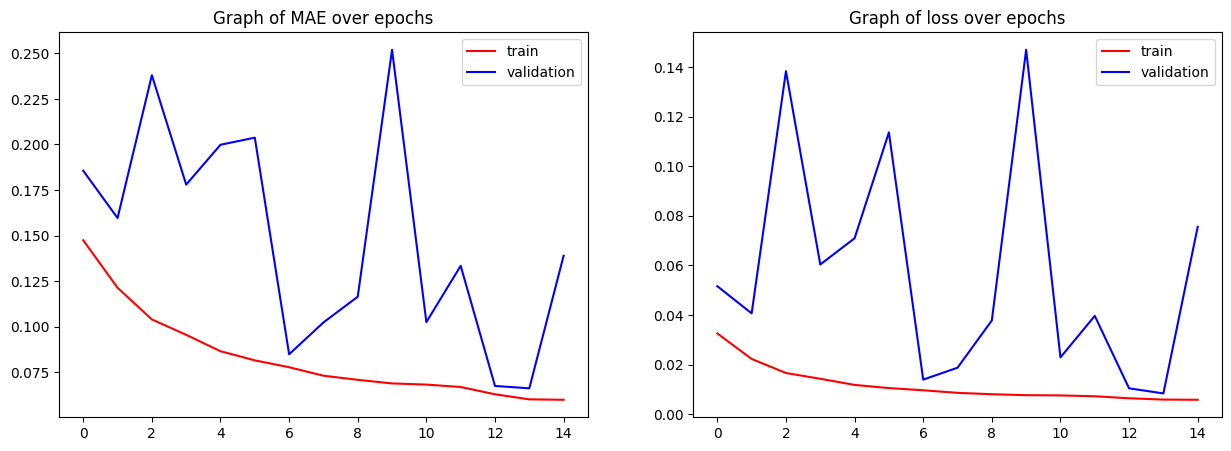

In [512]:
printplot(history)

In [513]:
model.save(f"model-5_accuracy={history.history['mae'][-1]:.4f}.h5")

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

MODEL_PATH = r"C:\Users\91909\Desktop\ML\NTIRE_2025\model-5_accuracy=0.0597.h5"
IMAGE_PATH = r"C:\Users\91909\Desktop\ML\DATA\NTIRE\noisy_data\DIV2K\noise\noise\0821.png"

# Load trained denoising model
model = tf.keras.models.load_model(MODEL_PATH)

def extract_patches(image, patch_size=PATCH_SIZE):
    """ Extracts overlapping patches from an image and stores their positions. """
    h, w, c = image.shape
    pad_h = (patch_size - h % patch_size) % patch_size
    pad_w = (patch_size - w % patch_size) % patch_size

    # Pad the image to ensure full patch coverage
    padded_image = cv2.copyMakeBorder(image, 0, pad_h, 0, pad_w, cv2.BORDER_REFLECT)
    patches, positions = [], []

    for i in range(0, padded_image.shape[0], patch_size):
        for j in range(0, padded_image.shape[1], patch_size):
            patch = padded_image[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
            positions.append((i, j))

    return np.array(patches), positions, (h, w), (padded_image.shape[0], padded_image.shape[1])

def stitch_patches(patches, positions, original_size, padded_size):
    """ Reconstructs an image from patches while handling padding. """
    h, w = original_size
    padded_h, padded_w = padded_size
    stitched_image = np.zeros((padded_h, padded_w, 3), dtype=np.float32)
    count_map = np.zeros((padded_h, padded_w, 1), dtype=np.float32)

    for patch, (i, j) in zip(patches, positions):
        stitched_image[i:i+PATCH_SIZE, j:j+PATCH_SIZE] += patch
        count_map[i:i+PATCH_SIZE, j:j+PATCH_SIZE] += 1

    # Normalize overlapping regions
    stitched_image /= np.maximum(count_map, 1)
    
    # Crop back to original size
    return stitched_image[:h, :w]

def visualize_results(original, denoised):
    """ Displays the original and denoised images side by side. """
    plt.figure(figsize=(15, 10))
    
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Noisy Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(denoised, cv2.COLOR_BGR2RGB))
    plt.title("Denoised Image")
    plt.axis("off")
    
    plt.show()

def denoise_image():
    """ Loads an image, processes patches through the model, and reconstructs the denoised image. """
    img = cv2.imread(IMAGE_PATH, cv2.IMREAD_COLOR) / 255.0 # Load image (BGR format)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0  # Convert to RGB and normalize
    
    patches, positions, original_size, padded_size = extract_patches(img)
    preds = model.predict(patches, batch_size=BATCH_SIZE)  # Predict denoised patches

    denoised_img = stitch_patches(preds, positions, original_size, padded_size)

    # Convert back to BGR for OpenCV display or save
    denoised_img_bgr = cv2.cvtColor((denoised_img * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)

    visualize_results(cv2.imread(IMAGE_PATH), denoised_img_bgr)

denoise_image()